In [1]:
import warnings

from itertools import product

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpyro

from matplotlib import MatplotlibDeprecationWarning
from numpy.random import default_rng

warnings.filterwarnings(action="ignore")

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data:
data = pd.read_csv('data/anemones.csv')

In [3]:
xy = data[["x", "y"]].values

# Jitter the data slightly so that none of the points fall exactly
# on cell boundaries
eps = 1e-3
rng = default_rng()
xy = xy.astype("float") + rng.standard_normal(xy.shape) * eps

resolution = 20

# Rescaling the unit of area so that our parameter estimates
# are easier to read
area_per_cell = resolution**2 / 100

cells_x = int(280 / resolution)
cells_y = int(180 / resolution)

# Creating bin edges for a 2D histogram
quadrat_x = np.linspace(0, 280, cells_x + 1)
quadrat_y = np.linspace(0, 180, cells_y + 1)

# Identifying the midpoints of each grid cell
centroids = np.asarray(list(product(quadrat_x[:-1] + 10, quadrat_y[:-1] + 10)))

cell_counts, _, _ = np.histogram2d(xy[:, 0], xy[:, 1], [quadrat_x, quadrat_y])
cell_counts = cell_counts.ravel().astype(int)

In [4]:
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro import sample, deterministic
import arviz as az
import matplotlib.pyplot as plt
from numpyro.infer import MCMC, NUTS, Predictive

In [6]:
import jax.numpy as jnp
from jax import jit

In [51]:
def matern52_kernel(x1, x2, sigma=1.0, lengthscale=1.0):
    """
    compute the Matérn-5/2 kernel matrix between two sets of points

    args:
    - x1 (array): array of shape (n1, d) representing the first set of points
    - x2 (array): array of shape (n2, d) representing the second set of points
    - sigma (float): variance
    - length_scale (float): length-scale

    returns:
    - K (array): kernel matrix of shape (n1, n2)
    """
    dist = jnp.sqrt(jnp.sum((x1[:, None] - x2) ** 2, axis=-1))
    arg = dist / lengthscale
    return sigma**2 * (1 + jnp.sqrt(5) * arg + 5/3 * arg**2) * jnp.exp(-jnp.sqrt(5) * arg)

# compile the kernel function for better performance
matern52_kernel = jit(matern52_kernel)

In [52]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def constant_mean_function(mu):
    def mean_func(x):
        return jnp.full(x.shape[:-1] + (1,), mu)
    return mean_func

In [9]:
def lgcp_model(x = centroids):
    # Prior for mean
    mu = sample("mu", dist.Normal(0, 3))
    # Prior for length scale
    rho = sample("rho", dist.Uniform(25, 300))
    # Prior for variance using InverseGamma directly
    variance = sample("variance", dist.InverseGamma(1.0, 1.0))
    # creating covariance function:
    kernel = matern52_kernel(x, x, sigma=2, lengthscale=rho)
    cov_func = variance * kernel
    mean_func = constant_mean_function(mu)

    mean = mean_func(x)

    log_intensity = sample("log_intensity", 
                           dist.MultivariateNormal(
                               loc=mean, covariance_matrix=cov_func
                               ))
    # Intensity and Poisson likelihood
    intensity = jnp.exp(log_intensity)
    rates = intensity * area_per_cell

    with numpyro.plate("observations", len(cell_counts)):
        sample("counts", 
               dist.Poisson(rates), 
               obs=cell_counts)



In [13]:
# MCMC sampling
kernel = NUTS(lgcp_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000)

In [14]:
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key)

sample: 100%|██████████| 2000/2000 [2:16:20<00:00,  4.09s/it, 511 steps of size 2.14e-02. acc. prob=0.91]  


In [15]:
# get the posterior samples
posterior_samples = mcmc.get_samples()

# print summary statistics of posterior
mcmc.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
    log_intensity[0,0]     -0.89      0.15     -0.89     -1.11     -0.61   1275.59      1.00
    log_intensity[0,1]     -0.89      0.15     -0.89     -1.15     -0.66   2137.48      1.00
    log_intensity[0,2]     -0.88      0.16     -0.88     -1.14     -0.63   1668.96      1.00
    log_intensity[0,3]     -0.86      0.16     -0.86     -1.12     -0.62   1772.98      1.00
    log_intensity[0,4]     -0.85      0.16     -0.85     -1.13     -0.61   1584.28      1.00
    log_intensity[0,5]     -0.85      0.16     -0.86     -1.13     -0.63   1701.19      1.00
    log_intensity[0,6]     -0.83      0.15     -0.82     -1.09     -0.59   1610.25      1.00
    log_intensity[0,7]     -0.79      0.15     -0.79     -1.06     -0.57   1534.39      1.00
    log_intensity[0,8]     -0.77      0.15     -0.78     -1.02     -0.53   1562.33      1.00
    log_intensity[0,9]     -0.88      0.16     -0.87     -1.15     -0

In [19]:
# Create an ArviZ InferenceData object
inference_data = az.from_numpyro(mcmc)

# Get summary for specific parameters
summary = az.summary(inference_data, var_names=['mu', 'rho', 'variance'])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [20]:
print(summary)

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu        -0.804  0.007  -0.818   -0.791      0.000    0.000     497.0   
rho       29.536  1.366  27.159   31.978      0.502    0.373       8.0   
variance   0.007  0.000   0.006    0.008      0.000    0.000     129.0   

          ess_tail  r_hat  
mu           625.0    NaN  
rho           24.0    NaN  
variance     219.0    NaN  


In [22]:
# save mcmc model:
import arviz as az

# Convert to InferenceData
inference_data = az.from_numpyro(mcmc)

# Save to NetCDF file
inference_data.to_netcdf("mcmc_results.nc")


# #### Load the model
# loaded_data = az.from_netcdf("mcmc_results.nc")


'mcmc_results.nc'

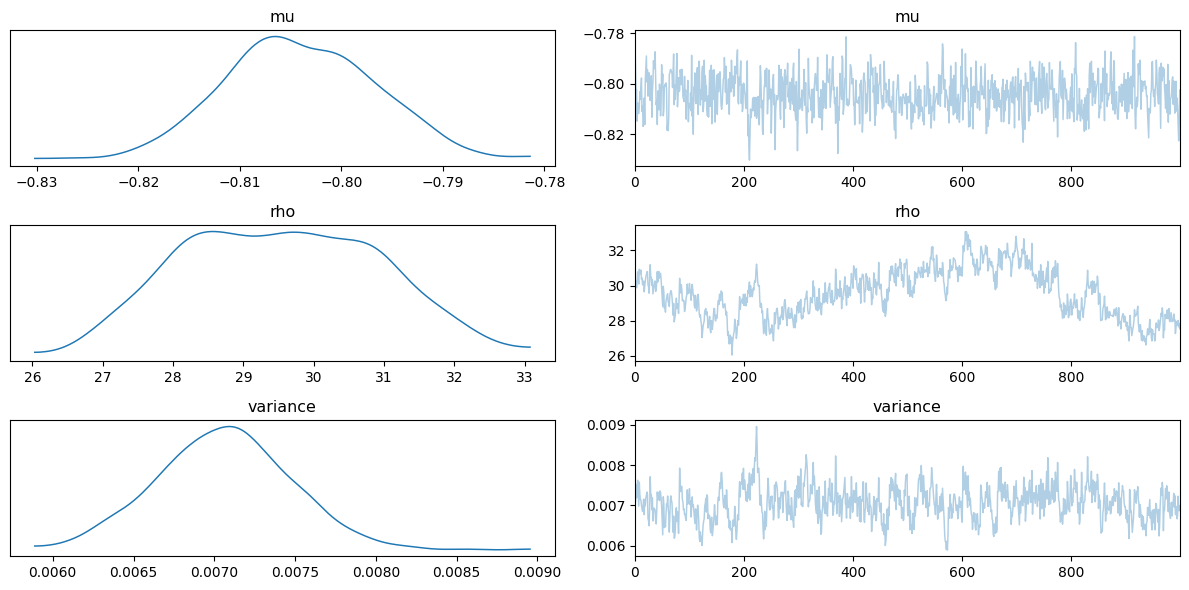

In [24]:
# Plot trace for specific parameters
az.plot_trace(inference_data, var_names=['mu', 'rho', 'variance'])
plt.tight_layout()
plt.show()

### Predictions

In [25]:
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

In [32]:
# Create new grid points
x_new = jnp.linspace(5, 275, 20)
y_new = jnp.linspace(5, 175, 20)
xs, ys = jnp.meshgrid(x_new, y_new)
xy_new = jnp.stack([xs.ravel(), ys.ravel()], axis=-1)


In [ ]:
def predictive_model(xy_new):
    print(f" shape of xy_new : {xy_new.shape}")
    # Extract parameters from the previous MCMC samples
    mu = mcmc.get_samples()['mu'][0]
    print(f"--- mu shape : {mu.shape} ---")
    rho = mcmc.get_samples()['rho'][0]
    print(f"--- mu shape : {rho.shape} ---")
    variance = mcmc.get_samples()['variance'][0]
    print(f"--- mu shape : {variance.shape} ---")
    
    # # Recreate the kernel and mean function for new points
    # def matern52_kernel(x1, x2, sigma, lengthscale):
    #     # Implement your Matern 5/2 kernel for new points
    #     # This should be consistent with your original kernel implementation
    #     dist = jnp.sqrt(jnp.sum((x1[:, None, :] - x2[None, :, :]) ** 2, axis=-1))
    #     scaled_dist = jnp.sqrt(5) * dist / lengthscale
    #     kernel = (sigma ** 2) * (1 + scaled_dist + (scaled_dist ** 2) / 3) * jnp.exp(-scaled_dist)
    #     return kernel
    
    # def constant_mean_function(mu):
    #     def mean_func(x):
    #         return jnp.full(x.shape[:-1] + (1,), mu)
    #     return mean_func

    # Compute kernel and mean for new points
    kernel_new = matern52_kernel(xy_new, xy_new, sigma=2, lengthscale=rho)
    cov_func_new = variance * kernel_new
    mean_func_new = constant_mean_function(mu)
    mean_new = mean_func_new(xy_new)

    # Sample log intensity for new points
    log_intensity_new = sample("log_intensity_new", 
                                dist.MultivariateNormal(
                                    loc=mean_new, 
                                    covariance_matrix=cov_func_new
                                ))
    return log_intensity_new


In [53]:
def predictive_model(xy_new):
    # Get the first sample from each parameter to ensure consistent shapes
    mu = mcmc.get_samples()['mu'][0]  # Take first sample
    rho = mcmc.get_samples()['rho'][0]
    variance = mcmc.get_samples()['variance'][0]
    
    # def matern52_kernel(x1, x2, sigma, lengthscale):
    #     dist = jnp.sqrt(jnp.sum((x1[:, None, :] - x2[None, :, :]) ** 2, axis=-1))
    #     scaled_dist = jnp.sqrt(5) * dist / lengthscale
    #     kernel = (sigma ** 2) * (1 + scaled_dist + (scaled_dist ** 2) / 3) * jnp.exp(-scaled_dist)
    #     return kernel
    
    # def constant_mean_function(mu):
    #     def mean_func(x):
    #         return jnp.full(x.shape[0], mu)
    #     return mean_func

    # Compute kernel and mean for new points
    kernel_new = matern52_kernel(xy_new, xy_new, sigma=2, lengthscale=rho)
    cov_func_new = variance * kernel_new
    mean_func_new = constant_mean_function(mu)
    mean_new = mean_func_new(xy_new)

    # Sample log intensity for new points
    log_intensity_new = sample("log_intensity_new", 
                                dist.MultivariateNormal(
                                    loc=mean_new, 
                                    covariance_matrix=cov_func_new
                                ))
    return log_intensity_new


In [54]:

# Create a Predictive object
rng_key = jax.random.PRNGKey(0)
predictive = Predictive(predictive_model, mcmc.get_samples())

# Sample posterior predictive
posterior_predictive = predictive(rng_key, xy_new=xy_new)

# Extract and convert log intensity to intensity
intensity_samples = jnp.exp(posterior_predictive['log_intensity_new'])

In [55]:
intensity_samples.shape

(1000, 400, 400)

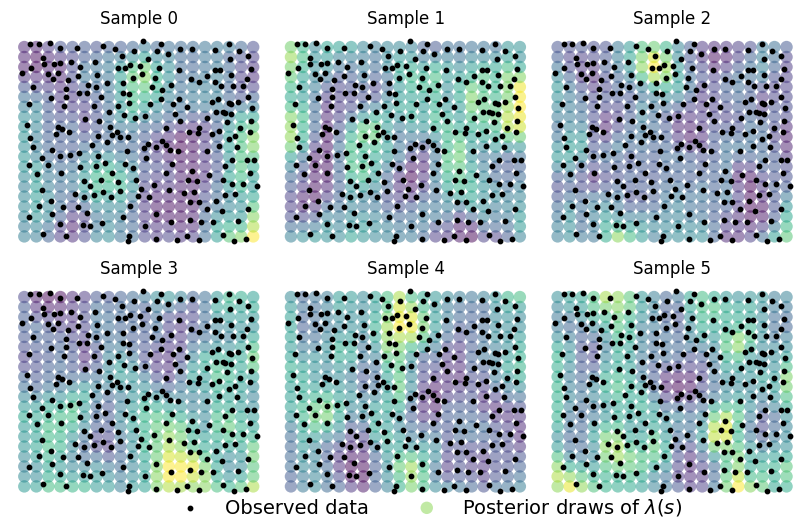

In [50]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Convert JAX array to NumPy for plotting
intensity_samples_np = np.array(intensity_samples)

fig, axes = plt.subplots(2, 3, figsize=(8, 5), constrained_layout=True)
axes = axes.ravel()

field_kwargs = {"marker": "o", "edgecolor": "None", "alpha": 0.5, "s": 80}

for i in range(6):
    field_handle = axes[i].scatter(
        xy_new[:, 0], xy_new[:, 1], 
        c=intensity_samples_np[i],  # Select the i-th draw
        **field_kwargs
    )

    obs_handle = axes[i].scatter(data["x"], data["y"], s=10, color="k")
    axes[i].axis("off")
    axes[i].set_title(f"Sample {i}")

plt.figlegend(
    (obs_handle, field_handle),
    ("Observed data", r"Posterior draws of $\lambda(s)$"),
    ncol=2,
    loc=(0.2, -0.01),
    fontsize=14,
    frameon=False
)

plt.show()

In [43]:
# Create a Predictive object
rng_key = jax.random.PRNGKey(0)
predictive = Predictive(predictive_model, mcmc.get_samples())


In [44]:
# Sample posterior predictive
posterior_predictive = predictive(rng_key, xy_new=xy_new)


 shape of xy_new : (400, 2)
--- mu shape : (1000,) ---
--- mu shape : (1000,) ---
--- mu shape : (1000,) ---


ValueError: Incompatible shapes for broadcasting: shapes=[(400, 400), (1000,)]